In [1]:
import pandas as pd
import os
import random
import numpy as np
from copy import deepcopy

seed = 123
random.seed(seed)

In [2]:
def get_mcsa_normal_dataset(dir, subset=['train', 'valid']):
    dataset = pd.DataFrame()
    for dataset_flag in subset:
        sub_df = pd.read_csv(os.path.join(dir, f'{dataset_flag}_dataset', f'mcsa_{dataset_flag}.csv'))
        sub_df['dataset_flag'] = [dataset_flag for _ in range(len(sub_df))]
        dataset = pd.concat([dataset, sub_df])
        
    return dataset

def site_labels_to_protected_positions(site_labels):
    protected_positions = []
    for one_site in site_labels:
        if len(one_site) == 1:
            protected_positions.append(one_site[0]-1)          # 这里的活性标签依然是从1开始算起，转为index需要减1
        elif len(one_site) == 2:
            b, e = one_site
            site_indices = [k - 1 for k in range(b, e+1)]
            protected_positions.extend(site_indices)
        else:
            raise ValueError(
                'The label of active site is not standard !!!')
    return protected_positions

def protected_positions_to_site_labels(protected_positions): 
    site_labels = [[x+1] for x in protected_positions]     # 互转加1
    return site_labels
    

def mutate_sequence(sequence, mutation_rate, insertion_rate, deletion_rate, max_length, protected_positions=None, trim_buffer=10):
    """
    Mutate, insert, and delete residues from an amino acid sequence, 
    avoiding mutations at specified protected positions and ensuring 
    the final sequence is not longer than max_length.
    
    Parameters:
        sequence (str): The initial amino acid sequence.
        mutation_rate (float): The fraction of residues to mutate [0, 1].
        insertion_rate (float): The fraction of residues to insert [0, 1].
        deletion_rate (float): The fraction of residues to delete [0, 1].
        max_length (int): The maximum allowable length of the sequence.
        protected_positions (list of int, optional): Positions that should not be mutated.
        trim_buffer (int, optional): Number of residues to retain around the first and last protected positions during trimming.
    
    Returns:
        str: The modified amino acid sequence.
    """
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    
    # Ensure sequence does not exceed max_length
    if len(sequence) > max_length:
        # Find the first and last protected positions
        first_protected = min(protected_positions) if protected_positions else 0
        last_protected = max(protected_positions) if protected_positions else len(sequence)
        
        # Determine trim positions, ensuring they are within valid range
        start_trim = max(first_protected - trim_buffer, 0)
        end_trim = min(last_protected + trim_buffer, len(sequence))
        
        # Trim the sequence
        sequence = sequence[start_trim:end_trim]
        # Update protected positions after trimming
        protected_positions = [p - start_trim for p in protected_positions if start_trim <= p <= end_trim]
    
    sequence_list = list(sequence)
    
    if protected_positions is None:
        protected_positions = []
    
    non_protected_positions = [i for i in range(len(sequence)) if i not in protected_positions]
    
    num_mutations = int(len(non_protected_positions) * mutation_rate)
    positions_to_mutate = random.sample(non_protected_positions, num_mutations)
    for pos in positions_to_mutate:
        original_aa = sequence_list[pos]
        new_aa = original_aa
        while new_aa == original_aa:
            new_aa = random.choice(amino_acids)
        sequence_list[pos] = new_aa
    
    num_insertions = int(len(sequence) * insertion_rate)
    for _ in range(num_insertions):
        if len(sequence_list) < max_length:  # Check to avoid exceeding max_length
            new_aa = random.choice(amino_acids)
            pos = random.randint(0, len(sequence_list))
            sequence_list.insert(pos, new_aa)
            protected_positions = [p + 1 if p >= pos else p for p in protected_positions]
    
    num_deletions = int(len(sequence) * deletion_rate)
    positions_to_delete = random.sample(range(len(sequence_list)), num_deletions)
    for pos in sorted(positions_to_delete, reverse=True):
        if pos not in protected_positions:
            del sequence_list[pos]
            protected_positions = [p - 1 if p > pos else p for p in protected_positions]
    
    return ''.join(sequence_list), protected_positions

In [3]:


# # Example usage:
# original_sequence = "MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHQYREQIKRVKDSDDVPMVLVGNKCDLAARTVESRQAQDLARSYGIPYIETSAKTRQGVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM"

# mutation_rate = 0.1  # mutate 10% of residues
# insertion_rate = 0.05  # insert a new residue for every 20 existing residues
# deletion_rate = 0.05   # delete 5% of residues
# max_length = 100  # restrict final sequence to no more than 100 residues
# protected_positions = [20, 31, 42]  # protect the first three residues from mutation

# modified_sequence, modified_protected_positions = mutate_sequence(original_sequence, mutation_rate, insertion_rate, deletion_rate, max_length, protected_positions)

# print("Original sequence:")
# print(original_sequence)
# print("\nModified sequence:")
# print(modified_sequence)
# print("\nModified protected positions:")
# print(modified_protected_positions)

# assert np.array(list(original_sequence))[protected_positions].tolist() == np.array(list(modified_sequence))[modified_protected_positions].tolist()




In [4]:
mcsa_train_valid_set = get_mcsa_normal_dataset('../dataset/mcsa_fine_tune/normal_mcsa', subset=['train', 'valid'])
mcsa_train_valid_set

,reaction,ec,alphafolddb-id,aa_sequence,site_labels,site_types,cluster,ec_level1,dataset_flag
0,CC1C(=O)N(C)C1C.O|MSIQHFRVALIPFFAAFCLPVFAHPETL...,3.5.2.6,P62593,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,"[[68], [71], [128], [164], [232], [235]]",NaN,Cluster 18632,3,train
1,CC1=C(C)C(=O)C(C)=C(C)C1=O.NC(=O)C1=CN([C@@H]2...,1.6.5.2,P15559,MVGRRALIVLAHSERTSFNYAMKEAAAAALKKKGWEVVESDLYAMN...,"[[150], [156], [162]]",NaN,Cluster 19381,1,train
2,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,1.8.1.7,P00390,MALLPRALSAGAGPSWRRAARAFRGFLLLLPEPAALTRALSRAMAC...,"[[102], [107], [110], [241], [245], [511], [516]]",NaN,Cluster 2616,1,train
3,O=C([O-])c1cccnc1C(=O)[O-].O=P([O-])([O-])OC[C...,2.4.2.19,P9WJJ7,MGLSDWELAAARAAIARGLDEDLRYGPDVTTLATVPASATTTASLV...,"[[105], [140], [172], [201], [222]]",NaN,Cluster 18704,2,train
4,CSCC[C@H]([NH3+])C(=O)[O-].Nc1ncnc2c1ncn2[C@@H...,2.5.1.6,P31153,MNGQLNGFHEAFIEEGTFLFTSESVGEGHPDKICDQISDAVLDAHL...,"[[29], [31], [32], [57], [70], [181], [250], [...",NaN,Cluster 9717,2,train
...,...,...,...,...,...,...,...,...,...
93,[NH3+][C@H](C=O)CCC(=O)[O-]|MVTSSPFKTIKSDEIFAA...,5.4.3.8,P24630,MVTSSPFKTIKSDEIFAAAQKLMPGGVSSPVRAFKSVGGQPIVFDR...,"[[150], [245], [273]]",NaN,Cluster 7309,5,valid
94,[NH3+][C@@H](CCC(=O)[O-])C(=O)[O-]|MKIGIFDSGVG...,5.1.1.3,P56868,MKIGIFDSGVGGLTVLKAIRNRYRKVDIVYLGDTARVPYGIRSKDT...,"[[7], [8], [70], [147], [178], [180]]",NaN,Cluster 20894,5,valid
95,CP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[...,6.1.1.11,Q46AN5,MKLQFNLKAYFKTSADPTPAKDAIAALFEEANSTLLTRGAPEGQGA...,"[[306], [336], [338], [347], [355], [416], [43...",NaN,Cluster 3619,6,valid
96,CP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[...,6.1.1.18,P00962,MSEAEARPTNFIRQIIDEDLASGKHTTVHTRFPPEPNGYLHIGHAK...,"[[35], [261], [271]]",NaN,Cluster 1462,6,valid


In [5]:
mcsa_train_valid_set
mcsa_train_valid_set.loc[mcsa_train_valid_set['alphafolddb-id'] == 'P81701']

,reaction,ec,alphafolddb-id,aa_sequence,site_labels,site_types,cluster,ec_level1,dataset_flag
469,CSc1ccccc1.OO|QTCSTSDDADDPTPPNERDDEAFASRVAAAKR...,1.11.1.18,P81701,QTCSTSDDADDPTPPNERDDEAFASRVAAAKRELEGTGTVCQINNG...,"[[341], [349], [411], [416], [417], [418], [48...",NaN,Cluster 1320,1,train
470,OO.Oc1ccccc1.Oc1ccccc1.[Br-].[Br-].[Br-]|QTCST...,1.11.1.18,P81701,QTCSTSDDADDPTPPNERDDEAFASRVAAAKRELEGTGTVCQINNG...,"[[341], [349], [411], [416], [417], [418], [48...",NaN,Cluster 1320,1,train
475,OO.[Br-].[H+]|QTCSTSDDADDPTPPNERDDEAFASRVAAAKR...,1.11.1.18,P81701,QTCSTSDDADDPTPPNERDDEAFASRVAAAKRELEGTGTVCQINNG...,"[[341], [349], [411], [416], [417], [418], [48...",NaN,Cluster 1320,1,train


In [6]:
'''生成增强序列（残基的突变, 增添, 缺失）序列, 追踪活性位点并返回, 依然保存为csv文档, 
最大序列长度与RFdiffusion文章一致为150, 但是保留活性位点前后10个氨基酸的长度, 所以不
是严格的150, 每条数据生成10个增强数据。
'''
from collections import defaultdict


aug_number = 40
mutation_rate = 0.35
insertion_rate = 0.1 
deletion_rate = 0.1
max_length = 150

train_valid_length_list = []
name_and_sequence = []

mcsa_aug_data_dir = f'../dataset/mcsa_fine_tune/mcsa_aug_{aug_number}_mutation_rate_{mutation_rate}_insertion_rate_{insertion_rate}_deletion_rate_{deletion_rate}_max_length_{max_length}_seed_{seed}'
os.makedirs(mcsa_aug_data_dir, exist_ok=True)

modified_uniprot_ids_counter = defaultdict(int)


for dataset_flag in ['train', 'valid', 'test']:
    aug_subset_save_dir = os.path.join(mcsa_aug_data_dir, f'{dataset_flag}_dataset')
    os.makedirs(aug_subset_save_dir, exist_ok=True)
    
    if dataset_flag != 'test':
        
        aug_subset_df = pd.DataFrame()

        subset_df = mcsa_train_valid_set.loc[mcsa_train_valid_set['dataset_flag']==dataset_flag]
        aug_subset_df = pd.DataFrame(columns=subset_df.columns)
        
        for index, row in subset_df.iterrows():
            original_sequence = row['aa_sequence']
            uniprot_id = row['alphafolddb-id']
            site_labels = eval(row['site_labels'])
            protected_positions = site_labels_to_protected_positions(site_labels)
            
            aug_subset_df.loc[len(aug_subset_df)] = row.tolist()
            
            for num in range(aug_number):
                modified_sequence, modified_protected_positions = mutate_sequence(original_sequence, mutation_rate, insertion_rate, deletion_rate, max_length, protected_positions)
                train_valid_length_list.append(len(modified_sequence))
                
                
                
                modified_site_labels = protected_positions_to_site_labels(modified_protected_positions)
                aug_row = deepcopy(row)
                aug_row['aa_sequence'] = modified_sequence
                aug_row['alphafolddb-id'] = f'{uniprot_id}-c{modified_uniprot_ids_counter[uniprot_id]}_m{num}'
                aug_row['site_labels'] = modified_site_labels
                
                name_and_sequence.append((f'{uniprot_id}-c{modified_uniprot_ids_counter[uniprot_id]}_m{num}', modified_sequence))
                
                aug_subset_df.loc[len(aug_subset_df)] = aug_row.tolist()
            
            modified_uniprot_ids_counter[uniprot_id] += 1
        

        aug_subset_df = aug_subset_df.reset_index(drop=True)
        aug_subset_df.to_csv(os.path.join(aug_subset_save_dir, f'aug_mcsa_{dataset_flag}.csv'), index=False)
    else:
        pd.read_csv('../dataset/mcsa_fine_tune/normal_mcsa/test_dataset/mcsa_test.csv').to_csv(os.path.join(aug_subset_save_dir, f'aug_mcsa_{dataset_flag}.csv'), index=False)

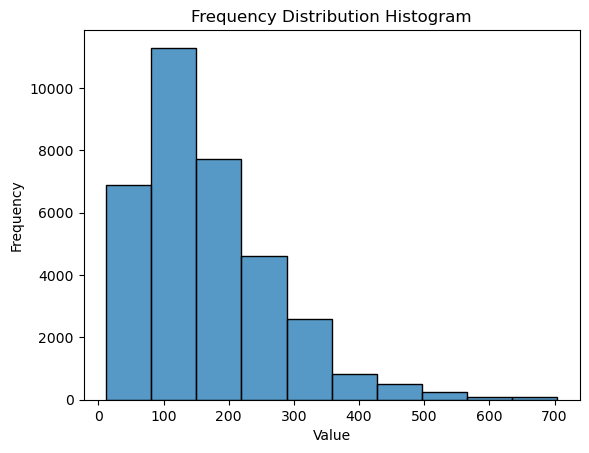

In [7]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# 使用pd.cut将数据分割成5个区间
bins = pd.cut(train_valid_length_list, bins=10)

# 使用pd.value_counts计算每个区间的频率
frequency = pd.value_counts(bins, sort=False)

# 使用seaborn绘制频率分布图
sns.histplot(train_valid_length_list, bins=10, kde=False)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency Distribution Histogram')
plt.show()


In [8]:
print(len(train_valid_length_list))

34840


In [9]:
# 制作fasta文件使用esmfold2生成新的3d结构（PDB文件）

with open(os.path.join(mcsa_aug_data_dir, 'train_valid_aug_sequence.fasta'), 'w') as f:
    for name, sequence in name_and_sequence:
        f.write(f'>{name}\n')
        f.write(f'{sequence}\n')

In [10]:
def get_mcsa_normal_dataset(dir, subset=['train', 'valid'], flag='mcsa', read_new=False):
    dataset = pd.DataFrame()
    for dataset_flag in subset:
        sub_df = pd.read_csv(os.path.join(dir, f'{dataset_flag}_dataset' if not read_new else f'new_{dataset_flag}_dataset', f'{flag}_{dataset_flag}.csv'))
        sub_df['dataset_flag'] = [dataset_flag for _ in range(len(sub_df))]
        dataset = pd.concat([dataset, sub_df])
    return dataset

In [11]:
end_aug_dataset = get_mcsa_normal_dataset(mcsa_aug_data_dir, subset=['train', 'valid'], flag='aug_mcsa', read_new=False)
end_aug_dataset

,reaction,ec,alphafolddb-id,aa_sequence,site_labels,site_types,cluster,ec_level1,dataset_flag
0,CC1C(=O)N(C)C1C.O|MSIQHFRVALIPFFAAFCLPVFAHPETL...,3.5.2.6,P62593,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,"[[68], [71], [128], [164], [232], [235]]",NaN,Cluster 18632,3,train
1,CC1C(=O)N(C)C1C.O|MSIQHFRVALIPFFAAFCLPVFAHPETL...,3.5.2.6,P62593-c0_m0,PIPNDAPMPSCVKVSCGSLSRGRAGGVQLGRCIYPQNHIEYSPVTE...,"[[10], [13], [65], [98], [159], [162]]",NaN,Cluster 18632,3,train
2,CC1C(=O)N(C)C1C.O|MSIQHFRVALIPFFAAFCLPVFAHPETL...,3.5.2.6,P62593-c0_m1,FRMEETFSMMSTVKVLKMGAVLPRVGCNEQLSRFIPNSMNDMVAYS...,"[[11], [14], [67], [98], [159], [162]]",NaN,Cluster 18632,3,train
3,CC1C(=O)N(C)C1C.O|MSIQHFRVALIPFFAAFCLPVFAHPETL...,3.5.2.6,P62593-c0_m2,FRPGEQFPVMSHKCELCMAVSRDAQEQLGQRSHTIQNDLVQAPWTE...,"[[11], [13], [64], [94], [157], [160]]",NaN,Cluster 18632,3,train
4,CC1C(=O)N(C)C1C.O|MSIQHFRVALIPFFAAFCLPVFAHPETL...,3.5.2.6,P62593-c0_m3,FEIRFPYMSGFKVLHNAVSRPVAMQEFSGNEVAGRQDYYPVTEKHK...,"[[9], [12], [60], [93], [158], [161]]",NaN,Cluster 18632,3,train
...,...,...,...,...,...,...,...,...,...
4013,NC(=[NH2+])NCCC[C@H]([NH2+]CCC(=O)[O-])C(=O)[O...,6.3.3.4,P0DJQ7-c0_m35,DGCEIPLLMYCPDRPAQLGGMWREDRLPLLKTLNPDMATIWDLCEM...,"[[10], [45], [106]]",NaN,Cluster 2977,6,valid
4014,NC(=[NH2+])NCCC[C@H]([NH2+]CCC(=O)[O-])C(=O)[O...,6.3.3.4,P0DJQ7-c0_m36,DGTERQNGTGYPAATLGGRHRDLEPALNKLAHCMAFGLNEMNKVLD...,"[[11], [40], [107]]",NaN,Cluster 2977,6,valid
4015,NC(=[NH2+])NCCC[C@H]([NH2+]CCC(=O)[O-])C(=O)[O...,6.3.3.4,P0DJQ7-c0_m37,DNPQRGILFTGWYGADQLANFHREDRLPALDTKVPVTMMTCFNGNE...,"[[13], [46], [106]]",NaN,Cluster 2977,6,valid
4016,NC(=[NH2+])NCCC[C@H]([NH2+]CCC(=O)[O-])C(=O)[O...,6.3.3.4,P0DJQ7-c0_m38,DGKTRRILADYGLIRPMGDHEDMDALPVWLAHDMAYTFDEQGVNEM...,"[[11], [45], [107]]",NaN,Cluster 2977,6,valid


In [12]:
end_aug_dataset.loc[end_aug_dataset['alphafolddb-id'] == 'P81701-c2_m12']

,reaction,ec,alphafolddb-id,aa_sequence,site_labels,site_types,cluster,ec_level1,dataset_flag
19488,OO.[Br-].[H+]|QTCSTSDDADDPTPPNERDDEAFASRVAAAKR...,1.11.1.18,P81701-c2_m12,ELYPRSSDYQKWQVHRFRPNAMGGHLLTIWGELFANIDPSLLEAAE...,"[[11], [18], [74], [78], [79], [80], [137], [1...",NaN,Cluster 1320,1,train
